In [1]:
import pandas as pd
import matplotlib.pyplot as pl
from keras.preprocessing.text import one_hot
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)




Using TensorFlow backend.


In [2]:
df_main=pd.read_json('train-v2.0.json')

In [3]:
df_main.head()

,version,data
0,v2.0,"{'title': 'Beyoncé', 'paragraphs': [{'qas': [{..."
1,v2.0,"{'title': 'Frédéric_Chopin', 'paragraphs': [{'..."
2,v2.0,{'title': 'Sino-Tibetan_relations_during_the_M...
3,v2.0,"{'title': 'IPod', 'paragraphs': [{'qas': [{'qu..."
4,v2.0,{'title': 'The_Legend_of_Zelda:_Twilight_Princ...


In [4]:
df_main.shape

(442, 2)

In [5]:
temp=df_main['data'][0]

In [6]:
par=temp['paragraphs']

In [7]:
ques=par[0]['qas']
ques[0]

{'question': 'When did Beyonce start becoming popular?',
 'id': '56be85543aeaaa14008c9063',
 'answers': [{'text': 'in the late 1990s', 'answer_start': 269}],
 'is_impossible': False}

In [8]:
title=[]
questions=[]
answers=[]
answer_start=[]
is_answerable=[]

In [9]:
for sample in df_main['data']:
    pars=sample['paragraphs']
    for par in pars:
        ques=par['qas']
        for i in ques:
            questions.append(i['question'])
            if i['answers']:
                answers.append(i['answers'][0]['text'])
                answer_start.append(i['answers'][0]['answer_start'])
            else:
                answers.append('Null')
                answer_start.append('Null')
            is_answerable.append(i['is_impossible'])

In [10]:
len(questions),len(answers),len(answer_start),len(is_answerable)

(130319, 130319, 130319, 130319)

In [11]:
df=pd.DataFrame({'Question':questions,
                 'Answers':answers,
                 'Answer_start':answer_start,
                 'Is_answerable':is_answerable
                })

In [12]:
df.head(10)

,Question,Answers,Answer_start,Is_answerable
0,When did Beyonce start becoming popular?,in the late 1990s,269,False
1,What areas did Beyonce compete in when she was...,singing and dancing,207,False
2,When did Beyonce leave Destiny's Child and bec...,2003,526,False
3,In what city and state did Beyonce grow up?,"Houston, Texas",166,False
4,In which decade did Beyonce become famous?,late 1990s,276,False
5,In what R&B group was she the lead singer?,Destiny's Child,320,False
6,What album made her a worldwide known artist?,Dangerously in Love,505,False
7,Who managed the Destiny's Child group?,Mathew Knowles,360,False
8,When did Beyoncé rise to fame?,late 1990s,276,False
9,What role did Beyoncé have in Destiny's Child?,lead singer,290,False


In [13]:
dev_data=pd.read_json('dev-v2.0.json')

In [14]:
questions=[]
answers=[]
answer_start=[]
is_answerable=[]
for sample in dev_data['data']:
    pars=sample['paragraphs']
    for par in pars:
        ques=par['qas']
        for i in ques:
            questions.append(i['question'])
            if i['answers']:
                answers.append(i['answers'][0]['text'])
                answer_start.append(i['answers'][0]['answer_start'])
            else:
                answers.append('Null')
                answer_start.append('Null')
            is_answerable.append(i['is_impossible'])
dev_df=pd.DataFrame({'Question':questions,
                 'Answers':answers,
                 'Answer_start':answer_start,
                 'Is_answerable':is_answerable
                })

In [15]:
dev_df

,Question,Answers,Answer_start,Is_answerable
0,In what country is Normandy located?,France,159,False
1,When were the Normans in Normandy?,10th and 11th centuries,94,False
2,From which countries did the Norse originate?,"Denmark, Iceland and Norway",256,False
3,Who was the Norse leader?,Rollo,308,False
4,What century did the Normans first gain their ...,10th century,671,False
...,...,...,...,...
11868,What is the seldom used force unit equal to on...,sthène,665,False
11869,What does not have a metric counterpart?,Null,Null,True
11870,What is the force exerted by standard gravity ...,Null,Null,True
11871,What force leads to a commonly used unit of mass?,Null,Null,True


<IPython.core.display.Javascript object>

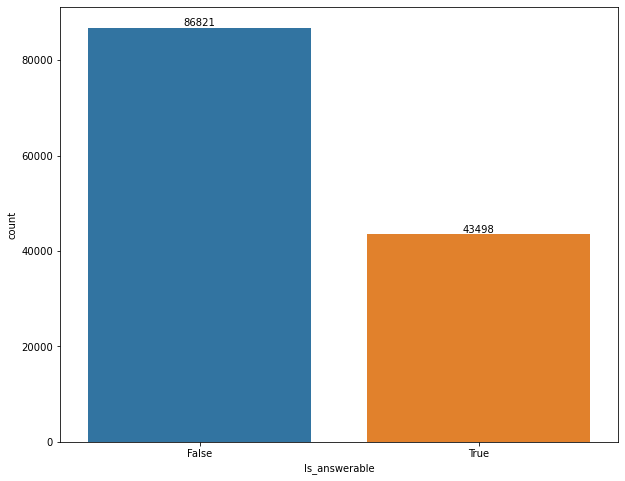

In [16]:
pl.figure(figsize=(10,8))

ax=sns.countplot(df['Is_answerable'])
rects=ax.patches

for rect in rects:
    height=rect.get_height()
    ax.text(x=rect.get_x()+rect.get_width()/2,y=height+5,s=height,ha='center',va='bottom')
pl.show()

<IPython.core.display.Javascript object>

-0.4 0.8
0.6 0.8


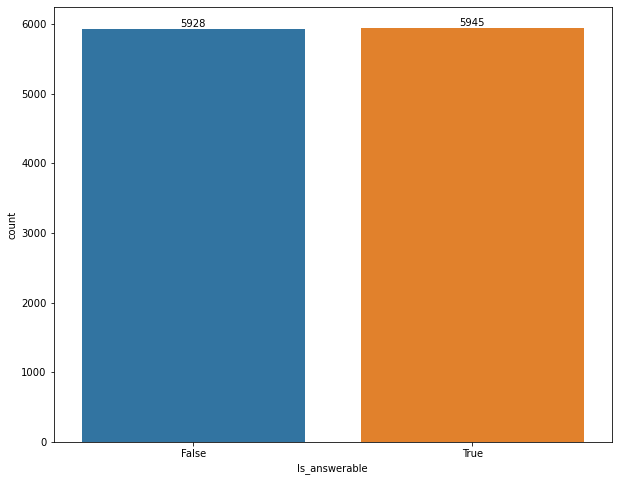

In [17]:
pl.figure(figsize=(10,8))

ax=sns.countplot(dev_df['Is_answerable'])
rects=ax.patches
for rect in rects:
    height=rect.get_height()
    print(rect.get_x(),rect.get_width())
    ax.text(x=rect.get_x()+rect.get_width()/2,y=height+1,s=height,ha='center',va='bottom')
pl.show()

In [18]:
len(df),df['Answer_start'].nunique()

(130319, 1604)

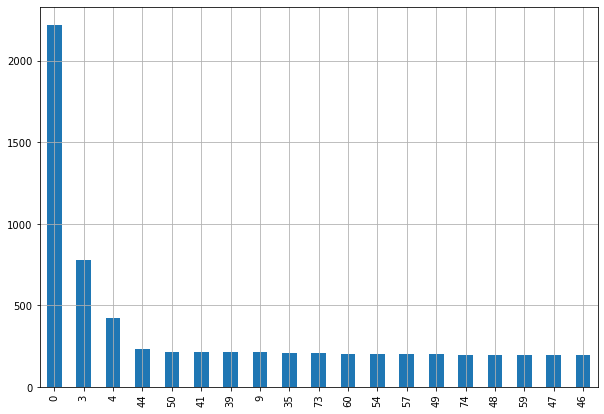

In [19]:
df['Answer_start'].value_counts()[1:20].plot(kind='bar',figsize=(10,7))
pl.grid()
pl.show()

In [23]:
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

In [24]:
df['len_que']=df['Question'].apply(lambda x: len(x))
df['len_ans']=df['Answers'].apply(lambda x: len(x))

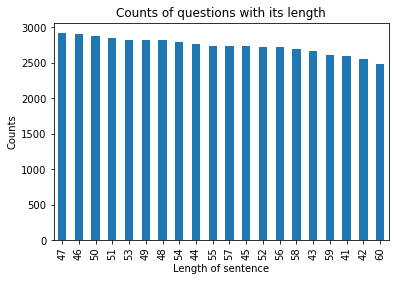

In [25]:
df['len_que'].value_counts()[:20].plot.bar()
pl.title('Counts of questions with its length')
pl.xlabel('Length of sentence')
pl.ylabel('Counts')
pl.show()

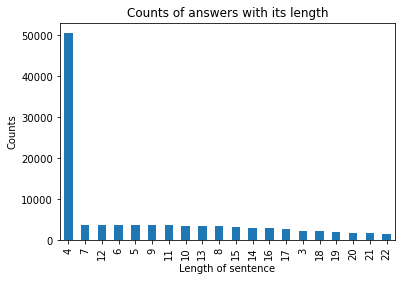

In [26]:
df['len_ans'].value_counts()[:20].plot.bar()
pl.title('Counts of answers with its length')
pl.xlabel('Length of sentence')
pl.ylabel('Counts')
pl.show()

In [27]:
df.describe()

,len_que,len_ans
count,130319.000000,130319.000000
mean,58.507739,14.758884
std,73.757111,19.193666
min,1.000000,1.000000
25%,44.000000,4.000000
50%,55.000000,7.000000
75%,69.000000,17.000000
max,25651.000000,239.000000


In [28]:
df.drop(107709,axis=0,inplace=True)

In [29]:
df.reset_index(drop=True,inplace=True)

In [30]:
df.head()

,Question,Answers,Answer_start,Is_answerable,len_que,len_ans
0,When did Beyonce start becoming popular?,in the late 1990s,269,False,40,17
1,What areas did Beyonce compete in when she was...,singing and dancing,207,False,58,19
2,When did Beyonce leave Destiny's Child and bec...,2003,526,False,64,4
3,In what city and state did Beyonce grow up?,"Houston, Texas",166,False,45,14
4,In which decade did Beyonce become famous?,late 1990s,276,False,42,10


In [31]:
len(df)

130318

In [43]:
df=df.sort_values('len_que',ascending=False)[5000:].copy()

In [50]:
df_s=df.sample(10000).copy()

In [51]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

In [52]:
for line,t in zip(df_s['Question'],df_s['Answers']):
    input_texts.append(line)
    target_texts.append(t)
    for char in line:
        if char not in input_characters:
            input_characters.add(char)
    for char in t:
        if char not in target_characters:
            target_characters.add(char)

In [53]:
print(input_characters)

{'/', '=', '⟨', 'd', 'V', 'T', 'Z', 'n', '3', 'W', '4', '6', 'l', 'H', '0', 'u', '1', '(', 'ü', 'θ', '❤', 'ź', 'h', '9', 'z', 'ā', '>', '$', 't', 'M', 'ī', 'w', 'x', 'E', ' ', 'Q', 'S', '5', 'v', 'a', 'j', 'i', 'ö', '+', 'N', 'ò', 'á', 'ѣ', 'ı', '−', 'q', "'", 'ḥ', 'é', ')', 'o', 'ó', 'O', '2', 'c', 'ć', '°', 'ð', '?', '.', 'X', 'R', 'k', '⟩', '!', '%', 'f', 'ñ', 'L', 'B', 'I', '*', 'P', 'í', 'Y', '7', 'J', 'U', 'Ḥ', 'm', 'b', 'C', ':', 'p', '-', ';', '_', 'F', 'y', '&', 's', ',', 'G', 'K', 'É', 'D', '"', 'e', '#', '8', 'r', 'g', 'A', '–'}


In [54]:
print(target_characters)

{'/', '⟨', '€', 'd', 'V', 'T', 'ô', 'Z', 'n', '3', 'ج', '4', 'W', 'ë', 'ß', '[', 'τ', 'έ', 'ʾ', '6', 'ç', 'l', 'H', '£', '0', 'ع', 'u', '1', 'Ḍ', 'ư', '(', 'ü', 'ś', 'h', '9', 'z', 'ā', 'ə', 'κ', '$', 't', 'ú', 'M', 'ν', 'ī', 'w', 'ę', 'x', 'E', ' ', '”', 'χ', '“', 'Q', 'S', '5', 'v', 'a', 'ˈ', 'j', 'i', 'è', 'ö', '+', 'N', 'ō', 'Ü', 'á', 'š', 'Ö', 'ι', '−', 'ã', 'q', "'", '—', ']', ')', 'é', 'o', 'ó', 'O', '2', 'c', 'ć', '°', '?', '.', 'ū', 'X', 'R', 'k', '⟩', 'ʻ', '!', '%', 'ω', 'f', '’', 'ñ', 'е', 'س', 'L', 'ż', 'B', 'I', 'P', 'í', 'Y', '7', 'J', 'U', 'b', 'm', 'â', 'ρ', 'C', 'ṣ', 'ɪ', ':', 'ä', '-', 'p', '₹', 'ἀ', ';', '×', 'F', 'ł', 'y', '&', 's', ',', 'G', 'K', 'ɒ', 'D', '"', 'e', '#', '8', 'ṃ', 'r', 'ï', 'g', 'ń', 'A', '–'}


In [55]:
input_characters=sorted(list(input_characters))
target_characters=sorted(list(target_characters))
num_encoder_tokens=len(input_characters)
num_decoder_tokens=len(target_characters)
max_encoder_len=max([len(txt) for txt in input_texts])
max_decoder_len=max([len(txt) for txt in target_texts])


print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_len)
print('Max sequence length for outputs:', max_decoder_len)

Number of samples: 10000
Number of unique input tokens: 109
Number of unique output tokens: 148
Max sequence length for inputs: 100
Max sequence length for outputs: 160


In [58]:
input_token_index=dict([(char,i) for i,char in enumerate(input_characters)])
target_token_index=dict([(char,i) for i,char in enumerate(target_characters)])

In [60]:
print(input_token_index)

{' ': 0, '!': 1, '"': 2, '#': 3, '$': 4, '%': 5, '&': 6, "'": 7, '(': 8, ')': 9, '*': 10, '+': 11, ',': 12, '-': 13, '.': 14, '/': 15, '0': 16, '1': 17, '2': 18, '3': 19, '4': 20, '5': 21, '6': 22, '7': 23, '8': 24, '9': 25, ':': 26, ';': 27, '=': 28, '>': 29, '?': 30, 'A': 31, 'B': 32, 'C': 33, 'D': 34, 'E': 35, 'F': 36, 'G': 37, 'H': 38, 'I': 39, 'J': 40, 'K': 41, 'L': 42, 'M': 43, 'N': 44, 'O': 45, 'P': 46, 'Q': 47, 'R': 48, 'S': 49, 'T': 50, 'U': 51, 'V': 52, 'W': 53, 'X': 54, 'Y': 55, 'Z': 56, '_': 57, 'a': 58, 'b': 59, 'c': 60, 'd': 61, 'e': 62, 'f': 63, 'g': 64, 'h': 65, 'i': 66, 'j': 67, 'k': 68, 'l': 69, 'm': 70, 'n': 71, 'o': 72, 'p': 73, 'q': 74, 'r': 75, 's': 76, 't': 77, 'u': 78, 'v': 79, 'w': 80, 'x': 81, 'y': 82, 'z': 83, '°': 84, 'É': 85, 'á': 86, 'é': 87, 'í': 88, 'ð': 89, 'ñ': 90, 'ò': 91, 'ó': 92, 'ö': 93, 'ü': 94, 'ā': 95, 'ć': 96, 'ī': 97, 'ı': 98, 'ź': 99, 'θ': 100, 'ѣ': 101, 'Ḥ': 102, 'ḥ': 103, '–': 104, '−': 105, '❤': 106, '⟨': 107, '⟩': 108}


In [61]:
print(target_token_index)

{' ': 0, '!': 1, '"': 2, '#': 3, '$': 4, '%': 5, '&': 6, "'": 7, '(': 8, ')': 9, '+': 10, ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '?': 27, 'A': 28, 'B': 29, 'C': 30, 'D': 31, 'E': 32, 'F': 33, 'G': 34, 'H': 35, 'I': 36, 'J': 37, 'K': 38, 'L': 39, 'M': 40, 'N': 41, 'O': 42, 'P': 43, 'Q': 44, 'R': 45, 'S': 46, 'T': 47, 'U': 48, 'V': 49, 'W': 50, 'X': 51, 'Y': 52, 'Z': 53, '[': 54, ']': 55, 'a': 56, 'b': 57, 'c': 58, 'd': 59, 'e': 60, 'f': 61, 'g': 62, 'h': 63, 'i': 64, 'j': 65, 'k': 66, 'l': 67, 'm': 68, 'n': 69, 'o': 70, 'p': 71, 'q': 72, 'r': 73, 's': 74, 't': 75, 'u': 76, 'v': 77, 'w': 78, 'x': 79, 'y': 80, 'z': 81, '£': 82, '°': 83, 'Ö': 84, '×': 85, 'Ü': 86, 'ß': 87, 'á': 88, 'â': 89, 'ã': 90, 'ä': 91, 'ç': 92, 'è': 93, 'é': 94, 'ë': 95, 'í': 96, 'ï': 97, 'ñ': 98, 'ó': 99, 'ô': 100, 'ö': 101, 'ú': 102, 'ü': 103, 'ā': 104, 'ć': 105, 'ę': 106, 'ī': 107, 'ł': 108, 'ń': 109, 'ō': 110,

In [63]:
import numpy as np
encoder_input_data=np.zeros(
    (len(input_texts),max_encoder_len,num_encoder_tokens),
    dtype='float32'
)
decoder_input_data=np.zeros(
    (len(target_texts),max_decoder_len,num_decoder_tokens),
    dtype='float32'
)

In [73]:
encoder_input_data.shape,decoder_input_data.shape

((10000, 100, 109), (10000, 160, 148))